In [1]:
!pip install pytorch-tabnet torch scikit-learn pandas matplotlib
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from pytorch_tabnet.tab_model import TabNetClassifier # This line should now work
import torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
np.random.seed(42)
torch.manual_seed(42)

In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data = pd.read_csv(url, names=column_names, na_values='?')

In [4]:
data['ca'] = pd.to_numeric(data['ca'], errors='coerce')
data['thal'] = pd.to_numeric(data['thal'], errors='coerce')
imputer = SimpleImputer(strategy='most_frequent')
data[['ca', 'thal']] = imputer.fit_transform(data[['ca', 'thal']])

In [5]:
data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)

In [6]:
X = data.drop('target', axis=1)
y = data['target']

In [7]:
categorical_features = [2, 6, 10, 11, 12]

In [8]:
for col in X.columns[categorical_features]:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

In [9]:
numerical_features = [0, 3, 4, 7, 9]  # age, trestbps, chol, thalach, oldpeak
scaler = StandardScaler()
X.iloc[:, numerical_features] = scaler.fit_transform(X.iloc[:, numerical_features])

In [10]:
X = X.values.astype(np.float32)
y = y.values.reshape(-1, 1).astype(np.int64)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Calculate cat_dims (number of unique values for each categorical feature)
cat_dims = [len(np.unique(X[:, idx])) for idx in categorical_features]

tabnet = TabNetClassifier(
    n_d=16,  # Dimension of prediction layer
    n_a=16,  # Dimension of attention layer
    n_steps=5,  # Number of sequential attention steps
    gamma=1.3,  # Coefficient for feature re-use
    cat_idxs=categorical_features,
    cat_dims=cat_dims,  # Provide cat_dims here
    cat_emb_dim=[4] * len(categorical_features),  # Embedding dimensions for categorical features
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax'  # Sparsemax activation for feature selection
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [13]:
# Convert y_train and y_test to 1-dimensional arrays
y_train = y_train.ravel()
y_test = y_test.ravel()

tabnet.fit(
    X_train, y_train,  # Pass the reshaped y_train
    eval_set=[(X_test, y_test)],  # Pass the reshaped y_test
    eval_name=['test'],
    max_epochs=100,
    patience=20,
    batch_size=32,
    virtual_batch_size=16,
    weights=1  # Handle class imbalance if needed
)

epoch 0  | loss: 0.94538 | test_auc: 0.75431 |  0:00:01s
epoch 1  | loss: 0.66368 | test_auc: 0.87392 |  0:00:01s
epoch 2  | loss: 0.66216 | test_auc: 0.87931 |  0:00:02s
epoch 3  | loss: 0.52951 | test_auc: 0.84591 |  0:00:02s
epoch 4  | loss: 0.53285 | test_auc: 0.82543 |  0:00:02s
epoch 5  | loss: 0.49273 | test_auc: 0.8556  |  0:00:03s
epoch 6  | loss: 0.49978 | test_auc: 0.90194 |  0:00:03s
epoch 7  | loss: 0.47715 | test_auc: 0.95582 |  0:00:03s
epoch 8  | loss: 0.46449 | test_auc: 0.95905 |  0:00:04s
epoch 9  | loss: 0.48475 | test_auc: 0.92672 |  0:00:04s
epoch 10 | loss: 0.46143 | test_auc: 0.91703 |  0:00:04s
epoch 11 | loss: 0.46724 | test_auc: 0.91379 |  0:00:05s
epoch 12 | loss: 0.452   | test_auc: 0.92241 |  0:00:05s
epoch 13 | loss: 0.51357 | test_auc: 0.90948 |  0:00:05s
epoch 14 | loss: 0.5332  | test_auc: 0.90625 |  0:00:06s
epoch 15 | loss: 0.42193 | test_auc: 0.91379 |  0:00:06s
epoch 16 | loss: 0.43361 | test_auc: 0.88039 |  0:00:07s
epoch 17 | loss: 0.39164 | test

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [14]:
y_pred = tabnet.predict(X_test)
y_proba = tabnet.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")


Accuracy: 0.8852
ROC AUC: 0.9591
F1 Score: 0.8923


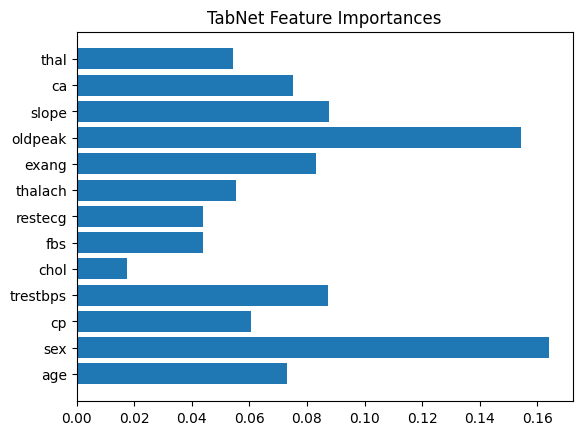

In [15]:
import matplotlib.pyplot as plt

feat_importances = tabnet.feature_importances_
plt.barh(column_names[:-1], feat_importances)
plt.title('TabNet Feature Importances')
plt.show()